In [4]:
from CADETProcess.processModel import ComponentSystem
from CADETProcess.processModel import StericMassAction
from CADETProcess.processModel import Inlet, GeneralRateModel, Outlet
from CADETProcess.processModel import FlowSheet
from CADETProcess.processModel import Process

# Component System
component_system = ComponentSystem()
component_system.add_component('Salt')
component_system.add_component('A')
component_system.add_component('B')
component_system.add_component('C')

# Binding Model
binding_model = StericMassAction(component_system, name='SMA')
binding_model.is_kinetic = True
binding_model.adsorption_rate = [0.0, 35.5, 1.59, 7.7]
binding_model.desorption_rate = [0.0, 1000, 1000, 1000]
binding_model.characteristic_charge = [0.0, 4.7, 5.29, 3.7]
binding_model.steric_factor = [0.0, 11.83, 10.6, 10]
binding_model.capacity = 1200.0

# Unit Operations
load = Inlet(component_system, name='load')
load.c = [150, 1.0, 1.0, 1.0]

wash = Inlet(component_system, name='wash')
wash.c = [50.0, 0.0, 0.0, 0.0]

elute = Inlet(component_system, name='elute')
elute.c = [500.0, 0.0, 0.0, 0.0]

column = GeneralRateModel(component_system, name='column')
column.binding_model = binding_model

column.length = 0.014
column.diameter = 0.02
column.bed_porosity = 0.37
column.particle_radius = 4.5e-5
column.particle_porosity = 0.75
column.axial_dispersion = 5.75e-8
column.film_diffusion = column.n_comp*[6.9e-6]
column.pore_diffusion = [7e-10, 6.07e-11, 6.07e-11, 6.07e-11]
column.surface_diffusion = column.n_bound_states*[0.0]

column.c = [50, 0, 0, 0]
column.cp = [50, 0, 0, 0]
column.q = [binding_model.capacity, 0, 0, 0]

outlet = Outlet(component_system, name='outlet')

# Flow Sheet
flow_sheet = FlowSheet(component_system)

flow_sheet.add_unit(load)#, feed_inlet=True)
flow_sheet.add_unit(wash)#, feed_inlet=True)
flow_sheet.add_unit(elute)#, eluent_inlet=True)
flow_sheet.add_unit(column)
flow_sheet.add_unit(outlet, product_outlet=True)

flow_sheet.add_connection(load, column)
flow_sheet.add_connection(wash, column)
flow_sheet.add_connection(elute, column)
flow_sheet.add_connection(column, outlet)

In [7]:
# Process
process = Process(flow_sheet, 'lwe')
process.cycle_time = 2000.0

load_duration = 10.0
t_gradient_start = 90.0
gradient_duration = process.cycle_time - t_gradient_start

wash_duration = t_gradient_start - load_duration

Q = 6.683738370512285e-8
gradient_slope = Q/(process.cycle_time - t_gradient_start)

process.add_event('load_on', 'flow_sheet.load.flow_rate', Q)
process.add_event('load_off', 'flow_sheet.load.flow_rate', 0)
process.add_duration('load_duration', time = load_duration)

process.add_event_dependency('load_off', ['load_on', 'load_duration'], [1, 1])

# # process.add_event('wash_on', 'flow_sheet.wash.flow_rate', Q)
# # process.add_event_dependency('wash_on', ['load_off'])
process.add_event('wash_on', 'flow_sheet.wash.flow_rate', Q, time=load_duration)
# process.add_event_dependency('wash_on', ['load_off'])


process.add_event('wash_off', 'flow_sheet.wash.flow_rate', 0)
process.add_duration('wash_duration', time=wash_duration)


process.add_event_dependency('wash_off', ['wash_on', 'wash_duration'])

process.add_event('elute_on', 'flow_sheet.elute.flow_rate', Q, time=t_gradient_start)
process.add_event_dependency('elute_on', ['wash_off'])





[[325.    0.5   0.5   0.5]
 [325.    0.5   0.5   0.5]
 [325.    0.5   0.5   0.5]
 ...
 [500.    0.    0.    0. ]
 [500.    0.    0.    0. ]
 [500.    0.    0.    0. ]]


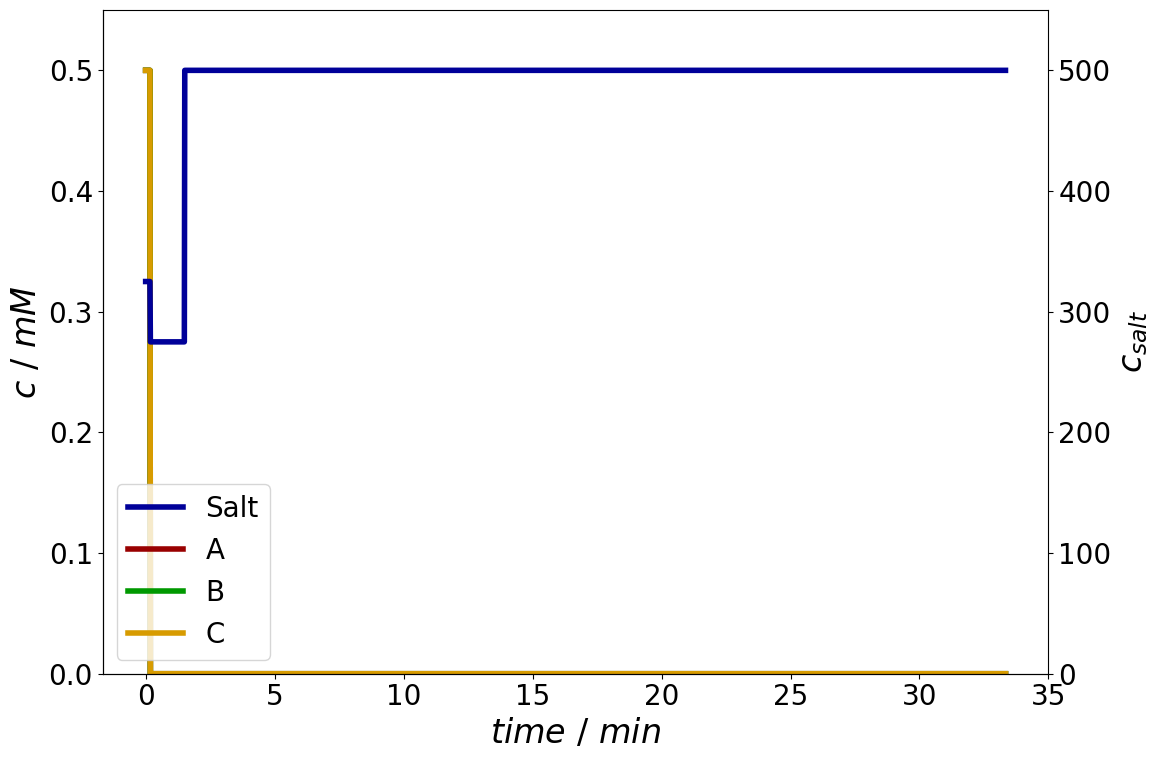

In [8]:
if __name__ == '__main__':
    from CADETProcess.simulator import Cadet
    process_simulator = Cadet()

    simulation_results = process_simulator.simulate(process)

    from CADETProcess.plotting import SecondaryAxis
    sec = SecondaryAxis()
    sec.components = ['Salt']
    sec.y_label = '$c_{salt}$'

    simulation_results.solution.column.inlet.plot(secondary_axis=sec)

    print(simulation_results.solution.column.inlet.total_concentration_components)
